## Init SAC

The _Soft Actor Critic_ (SAC) algorithm is an off-policy algorithm similar to DDPG and TD3, that
learns a stochastic policy instead. It adopts many of the techniques used in TD3, but it stems from
the _Maximum Entropy Formulation_ of reinforcement learning.

For an in-depth understanding of both max-ent and SAC, I suggest watching
[Lecture 1](https://www.youtube.com/watch?v=2GwBez0D20A&list=PLwRJQ4m4UJjNymuBM9RdmB3Z9N5-0IlY0&index=2)
of Peter Abbeel Deep RL course, and reading the OpenAI SpinningUp SAC summary.

In short and as a highlight, in this formulation of RL the optimization objective is to maximize the
expected return plus the _entropy_ of the policy $H[ \pi (a | s_t)]$, term that intuitively balance
exploration and exploitation:

$$
\max_{\pi} \mathbb{E}\Bigl[ \sum_{t=0}^{T} r_t + \beta H[ \pi (a | s_t)] \Bigr]
$$

The _entropy_ in fact "measures" how uncertain is a policy (i.e., a deterministic policy has a very
low entropy, while a random one has high entropy).

While the _critic_ network learns the action-value as usual, the _actor_ network learns the mean
and standard deviation of a Gaussian representing the stochastic policy, using `tanh` to "squash"
the values in an acceptable range, and having the `logstd` depending on the network parameters as
well.

In [11]:
%pip install stable-baselines3 numpy torch supersuit pettingzoo pymunk scipy gymnasium matplotlib

import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from stable_baselines3 import SAC

from __future__ import annotations

import glob
import os
import time

import supersuit as ss
from stable_baselines3 import PPO
from stable_baselines3.ppo import MlpPolicy

from stable_baselines3.ppo import CnnPolicy, MlpPolicy

from pettingzoo.butterfly import knights_archers_zombies_v10
from pettingzoo.sisl import multiwalker_v9
from pettingzoo.butterfly import pistonball_v6
from pettingzoo.classic import tictactoe_v3
from pettingzoo.atari import combat_tank_v3

# TO z jakiegoś tutorial trzeba bedzie zmienic na petting zoo lu binne MA env 
# from util.petting import DEVICE, init_random, MultiAgentReplayBuffer, soft_update_model_params
import gymnasium as gym
# from util.gymnastics import DEVICE, ReplayBuffer, gym_simulation
# from util.gymnastics import plot_scores, soft_update_model_params


Note: you may need to restart the kernel to use updated packages.


In [12]:
# For convenience, harcoding actions' interval [-2.0, 2.0]
ACTION_SCALE = 2.0

import numpy as np
import random
import torch
from collections import deque
# The device to use for PyTorch. Just defined here for convenience.
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# The default random seed used in the lectures.
DEFAULT_RANDOM_SEED=10

def init_random(env, seed=DEFAULT_RANDOM_SEED):
    """Initializes random generators for PettingZoo environments"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.use_deterministic_algorithms(True)
    if env is not None:
        env.reset(seed=seed)
    return env
   
class MultiAgentReplayBuffer:
    """Replay buffer for multi-agent reinforcement learning algorithms."""
    def __init__(self, buffer_size=int(2e5)):
        """Initialize separate buffers for each agent."""
        self.memory = {}  # Dictionary to store deque buffers for each agent
        self.buffer_size = buffer_size

    def add_agent(self, agent_id):
        """Create a replay buffer for a new agent if it doesn't already exist."""
        if agent_id not in self.memory:
            self.memory[agent_id] = deque(maxlen=self.buffer_size)

    def add(self, agent_id, state, action, reward, next_state, done):
        """Stores an experience for a specific agent."""
        if agent_id not in self.memory:
            self.add_agent(agent_id)
        e = (state, action, reward, next_state, done)
        self.memory[agent_id].append(e)

    def sample(self, agent_id, batch_size: int = 128):
        """Randomly samples experiences for a specific agent."""
        if len(self.memory[agent_id]) < batch_size:
            print(f"Not enough samples for agent {agent_id}: {len(self.memory[agent_id])} available, need {batch_size}")
            return None  # Not enough experiences to sample
        
        experiences = random.sample(self.memory[agent_id], k=batch_size)
        states, actions, rewards, next_states, dones = zip(*experiences)
        return (
            torch.tensor(states, dtype=torch.float32).to(DEVICE),
            torch.tensor(actions, dtype=torch.float32).to(DEVICE),
            torch.tensor(rewards, dtype=torch.float32).view(-1, 1).to(DEVICE),
            torch.tensor(next_states, dtype=torch.float32).to(DEVICE),
            torch.tensor(dones, dtype=torch.float32).view(-1, 1).to(DEVICE),
        )

    def __len__(self):
        """Return the total number of experiences across all agents."""
        return sum(len(buffer) for buffer in self.memory.values())



def soft_update_model_params(src: torch.nn.Module, dest: torch.nn.Module, tau=1e-3):
    """Soft updates model parameters (θ_dest = τ * θ_src + (1 - τ) * θ_src)."""
    for dest_param, src_param in zip(dest.parameters(), src.parameters()):
        dest_param.data.copy_(tau * src_param.data + (1.0 - tau) * dest_param.data)
 

## Neural Network Models

In [13]:
class ActorNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, fc1_units=400, fc2_units=300):
        super(ActorNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, fc1_units)
        nn.init.kaiming_normal_(self.fc1.weight)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        nn.init.kaiming_normal_(self.fc2.weight)
        self.fc3 = nn.Linear(fc2_units, action_size)
        nn.init.uniform_(self.fc3.weight,-3e-3, 3e-3)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = F.tanh(self.fc3(x))
        return x

In [14]:
class CriticNetwork(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, fcs1_units=400, fc2_units=300):
        super(CriticNetwork, self).__init__() 
        self.fc1 = nn.Linear(state_size + action_size, fcs1_units)
        nn.init.kaiming_normal_(self.fc1.weight)
        self.fc2 = nn.Linear(fcs1_units, fc2_units)
        nn.init.kaiming_normal_(self.fc2.weight)
        self.fc3 = nn.Linear(fc2_units, 1)
        nn.init.uniform_(self.fc3.weight,-3e-3, 3e-3)

    def forward(self, state, action):
        x = torch.cat((state, action), dim=1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x


## Training Loop

In [15]:
import os
import pickle
import torch
import matplotlib.pyplot as plt
def save_agents(agents, directory='saved_agents'):
    """
    Zapisuje stany wszystkich agentów do określonego katalogu.

    Args:
        agents (dict): Słownik agentów.
        directory (str): Ścieżka do katalogu, w którym zapisywać modele.
    """
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    for agent_id, agent in agents.items():
        agent_dir = os.path.join(directory, agent_id)
        if not os.path.exists(agent_dir):
            os.makedirs(agent_dir)
        
        # Zapisz aktora
        actor_path = os.path.join(agent_dir, 'actor.pth')
        torch.save(agent.actor.state_dict(), actor_path)
        
        # Zapisz krytyków
        critic1_path = os.path.join(agent_dir, 'critic1.pth')
        torch.save(agent.twin_critic_1.state_dict(), critic1_path)
        
        critic2_path = os.path.join(agent_dir, 'critic2.pth')
        torch.save(agent.twin_critic_2.state_dict(), critic2_path)
        
        print(f"Zapisano modele dla agenta {agent_id} w {agent_dir}")

def save_scores(scores, filename='training_scores.pkl'):
    """
    Zapisuje wyniki treningu do pliku.

    Args:
        scores (dict): Słownik wyników treningu.
        filename (str): Nazwa pliku do zapisu.
    """
    with open(filename, 'wb') as f:
        pickle.dump(scores, f)
    print(f"Wyniki treningu zapisane w {filename}")

def train_multi_agent_sac(env, agents, n_episodes=1000, max_t=500):
    scores = {agent_id: [] for agent_id in agents.keys()}
    
    # Add progress tracking
    print(f"Starting training for {n_episodes} episodes...")
    
    try:
        for i_episode in range(1, n_episodes+1):
            observations = env.reset(seed=DEFAULT_RANDOM_SEED)[0]
            episode_scores = {agent_id: 0 for agent_id in agents.keys()}
            
            # Add episode start logging
            print(f"\rEpisode {i_episode}/{n_episodes}", end="")
            
            for t in range(max_t):
                actions = {}
                for agent_id in env.agents:
                    obs = observations[agent_id]
                    if len(obs.shape) > 1:
                        obs = obs.flatten()
                    
                    actions[agent_id] = agents[agent_id].act(obs)
    
                next_observations, rewards, terminations, truncations, _ = env.step(actions)
                
                for agent_id in env.agents:
                    done = terminations[agent_id] or truncations[agent_id]
                    obs = observations[agent_id]
                    next_obs = next_observations[agent_id]
                    if len(obs.shape) > 1:
                        obs = obs.flatten()
                        next_obs = next_obs.flatten()
    
                    # Include agent_id when calling step()
                    agents[agent_id].step(agent_id, obs, actions[agent_id], rewards[agent_id], next_obs, done)
                    episode_scores[agent_id] += rewards[agent_id]
    
                observations = next_observations
                
                if all(terminations.values()) or all(truncations.values()):
                    break
            
            # Store scores and print more frequent updates
            for agent_id in agents.keys():
                scores[agent_id].append(episode_scores[agent_id])
                avg_score = np.mean(scores[agent_id][-100:])
    
            # Print every episode
            if i_episode % 1 == 0:
                print(f"\nEpisode {i_episode}/{n_episodes}")
                for agent_id in agents.keys():
                    avg_score = np.mean(scores[agent_id][-100:])
                    current_score = episode_scores[agent_id]
                    print(f'Agent {agent_id} - Current Score: {current_score:.2f}, Average Score: {avg_score:.2f}')
                print('-' * 50)
    
    except KeyboardInterrupt:
        print("\nTrening przerwany przez użytkownika. Zapisywanie modeli i wyników...")
        save_agents(agents, directory='saved_agents')
        save_scores(scores, filename='training_scores.pkl')
        plt.figure(figsize=(10, 6))
        
        for agent_id in env.possible_agents:
            plt.plot(scores[agent_id], label=f'Agent {agent_id}')
        plt.xlabel('Episode')
        plt.ylabel('Score')
        plt.title('Training Scores per Agent')
        plt.legend()
        plt.grid(True)
        
        plt.savefig('training_scores.png')
        print("Wykres zapisany jako 'training_scores.png'.")
        plt.show()
    
    # Po zakończeniu treningu, zapisz modele i wyniki
    print("\nTrening zakończony. Zapisywanie modeli i wyników...")
    save_agents(agents, directory='saved_agents')
    save_scores(scores, filename='training_scores.pkl')
    
    # Generowanie i zapisywanie wykresu wyników
    plt.figure(figsize=(10, 6))
    
    for agent_id in env.possible_agents:
        plt.plot(scores[agent_id], label=f'Agent {agent_id}')
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.title('Training Scores per Agent')
    plt.legend()
    plt.grid(True)
    
    # Zapisz wykres jako plik PNG
    plt.savefig('training_scores.png')
    print("Wykres zapisany jako 'training_scores.png'.")
    
    plt.show()
    
    print("\nTraining completed!")
    return scores


## SAC

In [16]:
class ActorNetworkSAC(nn.Module):
    def __init__(self, state_size, action_size, min_action=-1.0, max_action=1.0):
        super().__init__()
        self.fc1 = nn.Linear(state_size, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc_mean = nn.Linear(256, action_size)
        self.fc_logstd = nn.Linear(256, action_size)
        
        # Store action bounds
        self.min_action = min_action
        self.max_action = max_action
        self.action_scale = (max_action - min_action) / 2.0
        self.action_bias = (max_action + min_action) / 2.0

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        mean = self.fc_mean(x)
        log_std = self.fc_logstd(x)
        log_std = torch.tanh(log_std)        
        return mean, self.adjust_log_std(log_std)

    def get_action(self, x):
        mean, log_std = self(x)
        # std = log_std.exp()
        std = log_std.exp().clamp(min=1e-6, max=1e6)
        normal = torch.distributions.Normal(mean, std)
        sample = normal.rsample()
        
        # Squash sample between -1 and 1 using tanh
        action = torch.tanh(sample)
        
        # Scale action to proper range
        action = action * self.action_scale + self.action_bias
        
        log_prob = normal.log_prob(sample)
        # Enforce action bounds
        log_prob -= torch.log(self.action_scale * (1 - action.pow(2)) + 1e-6)
        return action, log_prob

    def adjust_log_std(self, log_std):
        # log_std_min, log_std_max = (-20, 2)
        log_std_min, log_std_max = (-20, 2) 
        return log_std_min + 0.5 * (log_std_max - log_std_min) * (log_std + 1)



In [17]:
def normalize_observation(obs, min_val=-10, max_val=10):
    """
    Normalizuje obserwację do zakresu [-1, 1] po klamrowaniu.
    
    Args:
        obs (np.ndarray): Obserwacja z środowiska.
        min_val (float): Minimalna wartość po klamrowaniu.
        max_val (float): Maksymalna wartość po klamrowaniu.
        
    Returns:
        np.ndarray: Znormalizowana obserwacja.
    """    
    obs = np.clip(obs, min_val, max_val)
    return (obs - min_val) / (max_val - min_val) * 2 - 1
class AgentSAC:
    def __init__(self, state_size, action_size, start_mem_size=128,
                 gamma=0.99, lr_actor=3e-4, lr_critic=3e-4, policy_freq=2, target_entropy=None):
        self.state_size = state_size
        self.action_size = action_size
        self.start_mem_size = start_mem_size
        self.gamma = gamma
        self.policy_freq = policy_freq
        self.t_step = 0

        # Actor Network
        self.actor = ActorNetworkSAC(state_size, action_size).to(DEVICE)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr_actor)

        # Twin Critic Networks
        self.twin_critic_1 = CriticNetwork(state_size, action_size).to(DEVICE)
        self.twin_critic_target_1 = CriticNetwork(state_size, action_size).to(DEVICE)
        self.twin_critic_target_1.load_state_dict(self.twin_critic_1.state_dict())
        self.twin_critic_target_1.eval()

        self.twin_critic_2 = CriticNetwork(state_size, action_size).to(DEVICE)
        self.twin_critic_target_2 = CriticNetwork(state_size, action_size).to(DEVICE)
        self.twin_critic_target_2.load_state_dict(self.twin_critic_2.state_dict())
        self.twin_critic_target_2.eval()

        # Critic Optimizer
        self.critic_optimizer = optim.Adam(
            list(self.twin_critic_1.parameters()) + list(self.twin_critic_2.parameters()),
            lr=lr_critic
        )

        # Replay Buffer
        self.memory = MultiAgentReplayBuffer()

        # Automatyczne dopasowanie entropii
        if target_entropy is None:
            self.target_entropy = -np.prod(action_size).item()
        else:
            self.target_entropy = target_entropy

        self.log_alpha = torch.zeros(1, requires_grad=True, device=DEVICE)
        self.alpha_optimizer = optim.Adam([self.log_alpha], lr=lr_actor)
        self.alpha = self.log_alpha.exp().detach()

    def step(self, agent_id, state, action, reward, next_state, done):
        """Store experience and trigger learning if memory is sufficient."""
        self.t_step += 1
        self.memory.add(agent_id, state, action, reward, next_state, done)

        # Learn if memory has enough samples
        if len(self.memory) > self.start_mem_size:
            experiences = self.memory.sample(agent_id)
            if experiences:
                self.learn(experiences)

    def learn(self, experiences):
        """Update actor and critic networks using sampled experiences."""
        states, actions, rewards, next_states, dones = experiences

        # Normalizacja stanów
        states = states.cpu().numpy()
        states = normalize_observation(states, -10, 10)
        states = torch.tensor(states, dtype=torch.float32).to(DEVICE)

        next_states = next_states.cpu().numpy()
        next_states = normalize_observation(next_states, -10, 10)
        next_states = torch.tensor(next_states, dtype=torch.float32).to(DEVICE)

        # Reshape tensors for consistency
        rewards = rewards.view(-1, 1)
        dones = dones.view(-1, 1)

        with torch.no_grad():
            # Target policy smoothing
            actions_next, log_pi_next = self.actor.get_action(next_states)
            entropy_term = self.alpha * log_pi_next.sum(dim=1, keepdim=True)

            # Compute target Q values
            Q_targets_next_1 = self.twin_critic_target_1(next_states, actions_next)
            Q_targets_next_2 = self.twin_critic_target_2(next_states, actions_next)
            Q_targets_next = torch.min(Q_targets_next_1, Q_targets_next_2) - entropy_term
            Q_values = rewards + (self.gamma * Q_targets_next * (1 - dones))

            if torch.isnan(Q_values).any():
                print("Q_values contain NaNs!")
                return

        # Compute current Q estimates
        Q_expected_1 = self.twin_critic_1(states, actions)
        Q_expected_2 = self.twin_critic_2(states, actions)

        if torch.isnan(Q_expected_1).any() or torch.isnan(Q_expected_2).any():
            print("Q_expected contain NaNs!")
            return

        # Critic Loss
        critic_loss = F.mse_loss(Q_expected_1, Q_values) + F.mse_loss(Q_expected_2, Q_values)

        if torch.isnan(critic_loss).any():
            print("critic_loss contains NaNs!")
            return

        # Update Critics
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.twin_critic_1.parameters(), max_norm=1.0)
        torch.nn.utils.clip_grad_norm_(self.twin_critic_2.parameters(), max_norm=1.0)
        self.critic_optimizer.step()

        # Update Actor Network
        if self.t_step % self.policy_freq == 0:
            actions_pred, log_pi = self.actor.get_action(states)
            entropy_term = self.alpha * log_pi.sum(dim=1, keepdim=True)

            # Compute actor loss
            Q_values_1 = self.twin_critic_1(states, actions_pred)
            Q_values_2 = self.twin_critic_2(states, actions_pred)
            Q_values = torch.min(Q_values_1, Q_values_2)

            if torch.isnan(Q_values).any():
                print("Q_values for actor contain NaNs!")
                return

            actor_loss = (entropy_term - Q_values).mean()

            if torch.isnan(actor_loss).any():
                print("actor_loss contains NaNs!")
                return

            print(f"Actor Loss: {actor_loss.item()} | Q_values: {Q_values.mean().item()} | Entropy Term: {entropy_term.mean().item()}")
            print(f"Critic Loss: {critic_loss.item()} | Q_expected_1: {Q_expected_1.mean().item()} | Q_expected_2: {Q_expected_2.mean().item()} | Q_values: {Q_values.mean().item()}")

            # Update Actor
            self.actor_optimizer.zero_grad()
            actor_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.actor.parameters(), max_norm=1.0)
            self.actor_optimizer.step()

            # Update entropy coefficient alpha
            alpha_loss = -(self.log_alpha * (log_pi.sum(dim=1, keepdim=True) + self.target_entropy).detach()).mean()
            self.alpha_optimizer.zero_grad()
            alpha_loss.backward()
            self.alpha_optimizer.step()
            self.alpha = self.log_alpha.exp().detach()

            # Soft update target critics
            soft_update_model_params(self.twin_critic_1, self.twin_critic_target_1, tau=1e-3)
            soft_update_model_params(self.twin_critic_2, self.twin_critic_target_2, tau=1e-3)



In [18]:
# Przykład użycia w klasie MultiAgentSAC
class MultiAgentSAC(AgentSAC):
    def __init__(self, state_size, action_size, **kwargs):
        super().__init__(state_size, action_size, **kwargs)
        self.actor = ActorNetworkSAC(
            state_size, 
            action_size,
            min_action=-1.0,
            max_action=1.0
        ).to(DEVICE)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-4)
        
        # Definiowanie minimalnych i maksymalnych wartości dla normalizacji
        self.min_vals = torch.full((state_size,), -10.0).to(DEVICE)
        self.max_vals = torch.full((state_size,), 10.0).to(DEVICE)
        
    def act(self, observation, add_noise=False):
        if observation is None:
            return None
        obs = normalize_observation(observation, -10, 10)
        state = torch.from_numpy(obs).float().to(DEVICE)
        with torch.no_grad():
            action, _ = self.actor.get_action(state)
            action = torch.clamp(action, -1.0, 1.0)
        # Sprawdzenie zakresu akcji
        assert action.min() >= -1.0 and action.max() <= 1.0, "Action out of bounds!"
        return action.cpu().numpy()



Possible agents: ['walker_0', 'walker_1']

Agent walker_0:
Observation space: (93,)
Action space: (4,)

Agent walker_1:
Observation space: (93,)
Action space: (4,)
Created agents: dict_keys(['walker_0', 'walker_1'])
Starting training for 100 episodes...
Episode 1/100Actor Loss: 31.262725830078125 | Q_values: -0.05403725802898407 | Entropy Term: 31.208688735961914
Critic Loss: 1846.533935546875 | Q_expected_1: -0.05223977565765381 | Q_expected_2: -0.03788914903998375 | Q_values: -0.05403725802898407
Actor Loss: 30.1815242767334 | Q_values: -0.036898329854011536 | Entropy Term: 30.144628524780273
Critic Loss: 1754.885986328125 | Q_expected_1: -0.03537376597523689 | Q_expected_2: 0.05286668613553047 | Q_values: -0.036898329854011536

Episode 1/100
Agent walker_0 - Current Score: -1.26, Average Score: -1.26
Agent walker_1 - Current Score: -3.17, Average Score: -3.17
--------------------------------------------------
Episode 2/100Actor Loss: 31.193538665771484 | Q_values: -0.057521443814039

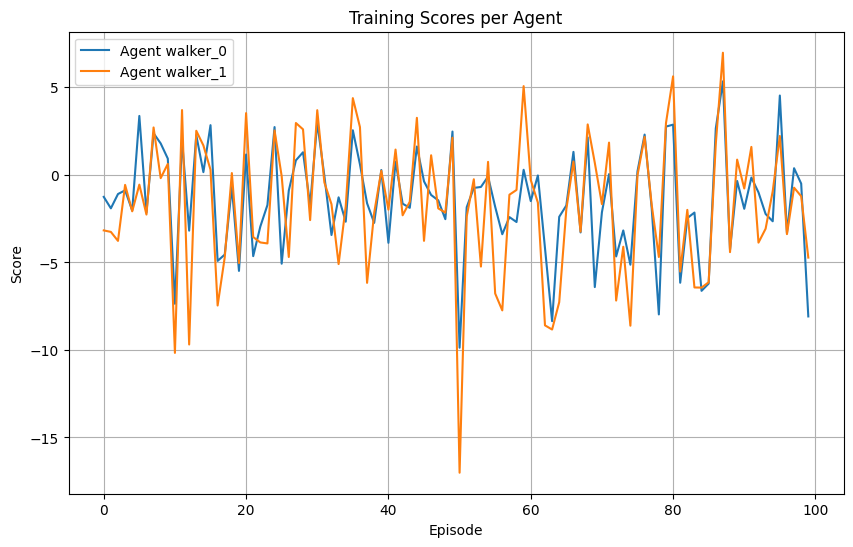


Training completed!
Zapisano modele dla agenta walker_0 w saved_agents/walker_0
Zapisano modele dla agenta walker_1 w saved_agents/walker_1


In [19]:

# env = multiwalker_v9.parallel_env(render_mode=None, n_walkers=2, shared_reward=False)
env = combat_tank_v3.parallel_env(render_mode="human", has_maze=True, is_invisible=False, billiard_hit=True)

env = ss.pad_observations_v0(env)
env = ss.pad_action_space_v0(env)
env = ss.frame_stack_v1(env, 3)

# env = ss.clip_observations_v0(env, lower_bound=-20, upper_bound=2000)
# env = ss.normalize_obs_v0(env)
# env = ss.clip_reward_v0(env, lower_bound=-1.0, upper_bound=10.0)
# Initialize random seeds
env = init_random(env)

# Print environment info for debugging
print("Possible agents:", env.possible_agents)
for agent_id in env.possible_agents:
    obs_space = env.observation_space(agent_id)
    act_space = env.action_space(agent_id)
    print(f"\nAgent {agent_id}:")
    print(f"Observation space: {obs_space.shape}")
    print(f"Action space: {act_space.shape}")

# Create agents for each entity
agents = {}
for agent_id in env.possible_agents:
    obs_space = env.observation_space(agent_id)
    act_space = env.action_space(agent_id)
    
    obs_dim = np.prod(obs_space.shape)
    act_dim = np.prod(act_space.shape)
    # act_dim = act_space.n
    
    agents[agent_id] = MultiAgentSAC(
        state_size=int(obs_dim),
        action_size=int(act_dim),
        start_mem_size=128,
        gamma=0.97, 
        lr_actor=1e-4, 
        lr_critic=1e-4, 
        policy_freq=2
    )

print("Created agents:", agents.keys())

# Train the agents
scores = train_multi_agent_sac(env, agents, n_episodes=100, max_t=400)

save_agents(agents, directory='saved_agents')

# plt.figure(figsize=(10, 6))

# # Debugging: Check data before plotting
# print("Environment agents:", env.possible_agents)
# for agent_id in env.possible_agents:
#     print(f"Agent {agent_id} observation space: {env.observation_space(agent_id)}")
#     print(f"Agent {agent_id} action space: {env.action_space(agent_id)}")

#     print(f"Agent {agent_id} scores: {scores[agent_id]}")
#     plt.plot(scores[agent_id], label=f'Agent {agent_id}')
    
# plt.xlabel('Episode')
# plt.ylabel('Score')
# plt.title('Training Scores per Agent')
# plt.legend()
# plt.grid(True)
# plt.show()


In [23]:
def load_agents(agents, directory='saved_agents'):
    """
    Ładuje stany wszystkich agentów z określonego katalogu.

    Args:
        agents (dict): Słownik agentów.
        directory (str): Ścieżka do katalogu, z którego ładować modele.
    """
    for agent_id, agent in agents.items():
        agent_dir = os.path.join(directory, agent_id)
        
        # Załaduj aktora
        actor_path = os.path.join(agent_dir, 'actor.pth')
        agent.actor.load_state_dict(torch.load(actor_path, map_location=DEVICE))
        
        # Załaduj krytyków
        critic1_path = os.path.join(agent_dir, 'critic1.pth')
        agent.twin_critic_1.load_state_dict(torch.load(critic1_path, map_location=DEVICE))
        
        critic2_path = os.path.join(agent_dir, 'critic2.pth')
        agent.twin_critic_2.load_state_dict(torch.load(critic2_path, map_location=DEVICE))
        
        print(f"Załadowano modele dla agenta {agent_id} z {agent_dir}")

def load_scores(filename='training_scores.pkl'):
    """
    Ładuje wyniki treningu z pliku.

    Args:
        filename (str): Nazwa pliku z zapisanymi wynikami.

    Returns:
        dict: Słownik wyników treningu.
    """
    with open(filename, 'rb') as f:
        scores = pickle.load(f)
    print(f"Wczytano wyniki treningu z {filename}")
    return scores

# Ładowanie agentów
load_agents(agents, directory='saved_agents')

# Ładowanie wyników treningu
loaded_scores = load_scores(filename='training_scores.pkl')

# Wizualizacja wczytanych wyników
plt.figure(figsize=(10, 6))

for agent_id in env.possible_agents:
    plt.plot(loaded_scores[agent_id], label=f'Agent {agent_id}')
plt.xlabel('Episode')
plt.ylabel('Score')
plt.title('Loaded Training Scores per Agent')
plt.legend()
plt.grid(True)

# Zapisz wykres jako plik PNG
plt.savefig('loaded_training_scores.png')
print("Wykres zapisany jako 'loaded_training_scores.png'.")

plt.show()


Załadowano modele dla agenta walker_0 z saved_agents/walker_0
Załadowano modele dla agenta walker_1 z saved_agents/walker_1


FileNotFoundError: [Errno 2] No such file or directory: 'training_scores.pkl'